# Mouse gliogenesis

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
import numpy as np
import optax
import orbax
import scanpy as sc
import uuid
import matplotlib.pyplot as plt

import stories

In [3]:
import jax

jax.devices()

[cuda(id=0)]

## Load the data

In [4]:
current_path = "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/stories/docs/vignettes/"

In [5]:
# Load the data
adata = ad.read_h5ad(current_path + "../../../data/dorsal_midbrain/dorsal_midbrain_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 4581 × 10000
    obs: 'CellID', 'Batch', 'annotation', 'S_score', 'G2M_score', 'phase', 'Time point', 'time', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'proliferation', 'apoptosis', 'growth'
    var: 'Gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    uns: 'FP200000600TR_E3', 'SS200000108BR_A3A4', 'SS200000108BR_B1B2', 'SS200000131BL_C3C4', 'SS200000131BL_C5C6', 'angle_dict', 'annotation_colors', 'hvg', 'neighbors', 'pca'
    obsm: 'X_isomap', 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connec

## Preprocess the data

In [6]:
# Some shorthands
space_key = "spatial"
omics_key = "X_pca_harmony"
time_key = "time"
weight_key = "growth"

In [7]:
# Select a given number of principal components then normalize the embedding.
adata.obsm[omics_key] = adata.obsm[omics_key][:, :20]
adata.obsm[omics_key] /= adata.obsm[omics_key].max()
print("Normalized embedding.")

Normalized embedding.


In [8]:
# Center and scale each batch in space.
adata.obsm[space_key] = adata.obsm[space_key].astype(float)
for b in adata.obs["Batch"].unique():
    idx = adata.obs["Batch"] == b

    mu = np.mean(adata.obsm[space_key][idx, :], axis=0)
    adata.obsm[space_key][idx, :] -= mu

    std = np.std(adata.obsm[space_key][idx, :], axis=0)
    adata.obsm[space_key][idx, :] /= std
print("Centered and scaled space.")

Centered and scaled space.


## Train the model

In [9]:
# Initialize the model.
model = stories.SpaceTime(quadratic_weight=1e-3)

In [19]:
# Define the checkpoint manager.
options = orbax.checkpoint.CheckpointManagerOptions(
    save_interval_steps=1,
    max_to_keep=1,
    best_fn=lambda x: x["loss"],
    best_mode="min",
)
checkpoint_manager = orbax.checkpoint.CheckpointManager(
    f"{current_path}ckpt{uuid.uuid4()}/checkpoints",
    options=options,
)

In [20]:
scheduler = optax.cosine_decay_schedule(1e-2, 10_000)
model.fit(
    adata=adata,
    time_key=time_key,
    omics_key=omics_key,
    space_key=space_key,
    weight_key=weight_key,
    optimizer=optax.adamw(scheduler),
    key=jax.random.PRNGKey(20_181),
    checkpoint_manager = checkpoint_manager,
)

 13%|█▎        | 1331/10000 [02:57<19:16,  7.50it/s, iteration=1332, train_loss=0.022216968, val_loss=0.08961417] 


Met early stopping criteria, breaking...


In [23]:
from orbax.checkpoint.args import StandardRestore

In [25]:
best_step = checkpoint_manager.best_step()
model.params = checkpoint_manager.restore(best_step, args=StandardRestore(model.params))

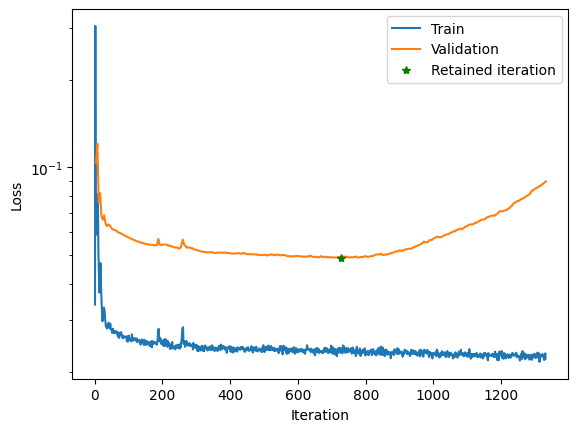

In [26]:
plt.plot(model.train_it, model.train_losses, label="Train")
plt.plot(model.val_it, model.val_losses, label="Validation")
plt.plot(best_step, model.val_losses[np.where(np.array(model.val_it) == best_step)[0][0]], "g*", label="Retained iteration")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.legend()
plt.yscale("log");

## Display the potential

In [ ]:
stories.tools.compute_potential(adata, model, "X_pca_harmony")

In [ ]:
sc.pl.embedding(
    adata, basis="isomap", color=["annotation", "potential"], vmax="p98", vmin="p02"
)

## Display the velocity

In [ ]:
stories.tools.compute_velocity(adata, model, "X_pca_harmony")

In [ ]:
palette = {"GlioB": "#008941ff", "NeuB": "#ff34ffff", "RGC": "#00bfffff"}

In [ ]:
stories.tools.plot_velocity(adata, "X_pca_harmony", basis="isomap", color="annotation", palette=palette, s=50)